In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
import os
path = os.getcwd()
os.chdir(path)

In [3]:
df_data2 = pd.read_excel("./dfprix.xlsx", index_col='Unnamed: 0') # lecture du dataframme

In [4]:
df_data2.head() # Visualisation de la base de données

,Date,Prix,Hôtel
0,2021-11-16,226.0,Room Mate Alain - Champs-Elysées
1,2021-11-16,132.0,Absolute Hotel Paris République
2,2021-11-16,196.0,Hôtel & Spa Saint Jacques
3,2021-11-16,146.0,Hotel de l'Aqueduc
4,2021-11-16,126.0,Hôtel Hor Les Lumières


# 2.1. Nettoyage du jeu de données

On vérifie que les variables sont bien exploitables en regardant leur type. Notamment, il faut vérifier si les observations de la colonne "Date" sont bien au format 'datetime' et si les prix sont au format numérique.

In [5]:
df_data2.dtypes

Date     datetime64[ns]
Prix            float64
Hôtel            object
dtype: object

On souhaite vérifier que, pour chaque hôtel de notre base de données, on a bien les prix de réservation pour chaque jour entre le 15 novembre et le 31 décembre. Pour cela, on effectue un tri par date et par hôtel, et on regarde les premières observations.

In [6]:
df_data2.sort_values(by = ["Hôtel", "Date"], ascending = True).head() # trier selon hotels et les prix

,Date,Prix,Hôtel
381,2021-11-19,134.0,55 Hôtel Montparnasse
795,2021-11-23,139.0,55 Hôtel Montparnasse
988,2021-11-25,129.0,55 Hôtel Montparnasse
1055,2021-11-26,119.0,55 Hôtel Montparnasse
1165,2021-11-27,139.0,55 Hôtel Montparnasse


On se rend compte que, au moins pour l'hôtel Montparnasse, nous n'observons pas l'évolution des prix sur l'ensemble de la période mi-novembre / fin-décembre. Il y a donc des "trous" correspondant à des jours manquants, dont on souhaite vérifier le nombre pour chaque hôtel de notre base de données.

In [7]:
Nb_Hotel = df_data2.groupby('Hôtel').agg({'Date': "count"}) 
Nb_Hotel.head()

,Date
Hôtel,
55 Hôtel Montparnasse,33
9Hotel Bastille-Lyon,27
Aberotel Montparnasse Eiffel,23
Absolute Hotel Paris République,43
Acacias Etoile,1


In [8]:
Nb_Hotel = Nb_Hotel.reset_index()

On s'intéresse aux hôtels pour lesquels on a le plus d'observations.

In [9]:
Nb_Hotel.sort_values(by ='Date',ascending=False).head(10) 

,Hôtel,Date
12,Au Royal Mad,48
73,Hotel Habituel,47
185,Le Pradey,45
14,Auteuil Tour Eiffel,44
129,Hôtel Bleu de Grenelle,44
54,Hotel Aida Marais,44
55,Hotel Aida Opera,44
64,Hotel Brady - Gare de l'Est,44
110,Hotel Whistler,44
236,TRIBE Paris Batignolles,44


Pour faciliter l'analyse de données qui suit, nous allons restreindre notre jeu de données aux hôtels pour lesquels on dispose de suffisamment d'observations (moins de 10 données manquantes), afin de pouvoir visualiser au mieux l'évolution des prix sur la période mi-novembre / fin décembre.

In [12]:
Nb_Hotel_more_than_40 = Nb_Hotel[Nb_Hotel['Date'] >= 40]
Nb_Hotel_more_than_40.head()
# ce code permet de mettre dans un autre dataframe la liste des hôtels ayant au moins 40 observations.

,Hôtel,Date
3,Absolute Hotel Paris République,43
10,Atlantic Hotel,40
11,Au Pacific Hotel,40
12,Au Royal Mad,48
14,Auteuil Tour Eiffel,44


In [12]:
df_reduit=df_data2[df_data2['Hôtel'].isin(Nb_Hotel_more_than_40 ['Hôtel'])]
# base de données réduite aux hôtels pour lesquels on a au moins 40 observations

On vérifie que l'on a suffisamment d'hôtels dans notre base de données. En particulier, comme notre échantillon réduit est de taille supérieure à 30, on pourra généraliser les résultats obtenus (comme la moyenne des prix de notre échantillon) avec une certaine précision d'après la loi des grands nombres.

In [13]:
df_reduit['Hôtel'].nunique()

36

# 2.2. Analyse de l'évolution des prix en fonction des hôtels

Dans cette partie, nous étudions les facteurs qui pourraient expliquer une plus grande dispersion du prix des hôtels sur notre période.

In [14]:
group_moy = df_reduit.groupby('Hôtel').agg([np.mean, np.std, np.min, np.max])['Prix'] 

In [15]:
group_moy = group_moy.reset_index()

In [16]:
group_moy.describe()

,mean,std,amin,amax
count,36.000000,36.000000,36.000000,36.000000
mean,172.368335,30.256204,129.638889,260.000000
std,58.498670,15.282537,46.041691,103.454614
min,50.729167,1.356608,49.000000,54.000000
25%,133.609012,20.632227,98.500000,204.500000
50%,159.712500,27.518708,120.000000,254.500000
75%,210.869338,35.869310,147.000000,299.750000
max,360.857143,82.504129,303.000000,565.000000


In [17]:
group_moy.sort_values(by ='mean',ascending=False).head(5)
# tri selon les prix moyens

,Hôtel,mean,std,amin,amax
19,Hotel Villa Marquis Member of Meliá Collection,360.857143,54.078340,303.0,546.0
29,Le Pradey,308.577778,82.504129,215.0,565.0
18,Hotel Paris Opera Affiliated by Meliá,237.697674,32.633269,186.0,330.0
31,Melia Paris Champs Elysées,226.170732,29.494832,177.0,294.0
27,Hôtel Paris Louvre Opéra,220.707317,44.640365,158.0,344.0


Les cinq hôtels ayant les prix moyens les plus élevés sur la période sont : 
- Hotel Villa Marquis Member of Meliá Collection
- Le Pradey
- Hotel Paris Opera Affiliated by Meliá
- Melia Paris Champs Elysées
- Hôtel Paris Louvre Opéra

Toutefois, la dispersion des prix n'est pas la même entre ces hôtels. Par exemple, les prix de réservation pour l'hôtel Melia Paris Champs Elysées fluctuent moins (sur la période qui nous intéresse) que ceux pour l'hôtel Le Pradey.

In [18]:
group_moy.sort_values(by ='mean',ascending=False).tail(5)

,Hôtel,mean,std,amin,amax
14,Hotel Ariane Montparnasse by Patrick Hayat,126.536585,13.375533,93.0,147.0
6,Campanile Hotel Paris Bercy Village,105.625000,20.661729,78.0,143.0
16,Hotel Habituel,104.936170,18.908710,96.0,166.0
2,Au Pacific Hotel,96.825000,1.356608,96.0,99.0
3,Au Royal Mad,50.729167,1.553850,49.0,54.0


Les trois hôtels ayant les prix moyens les plus élevés sur la période sont : 
- Au Royal Mad
- Au Pacific Hotel
- Hotel Habituel

On remarque que les prix des hôtels les moins chers varient moins que ceux les plus chers.

Sur le graphique ci-dessous, on représente l'évolution du prix des hôtels de la base de données réduite entre mi-novembre et fin décembre 2021.

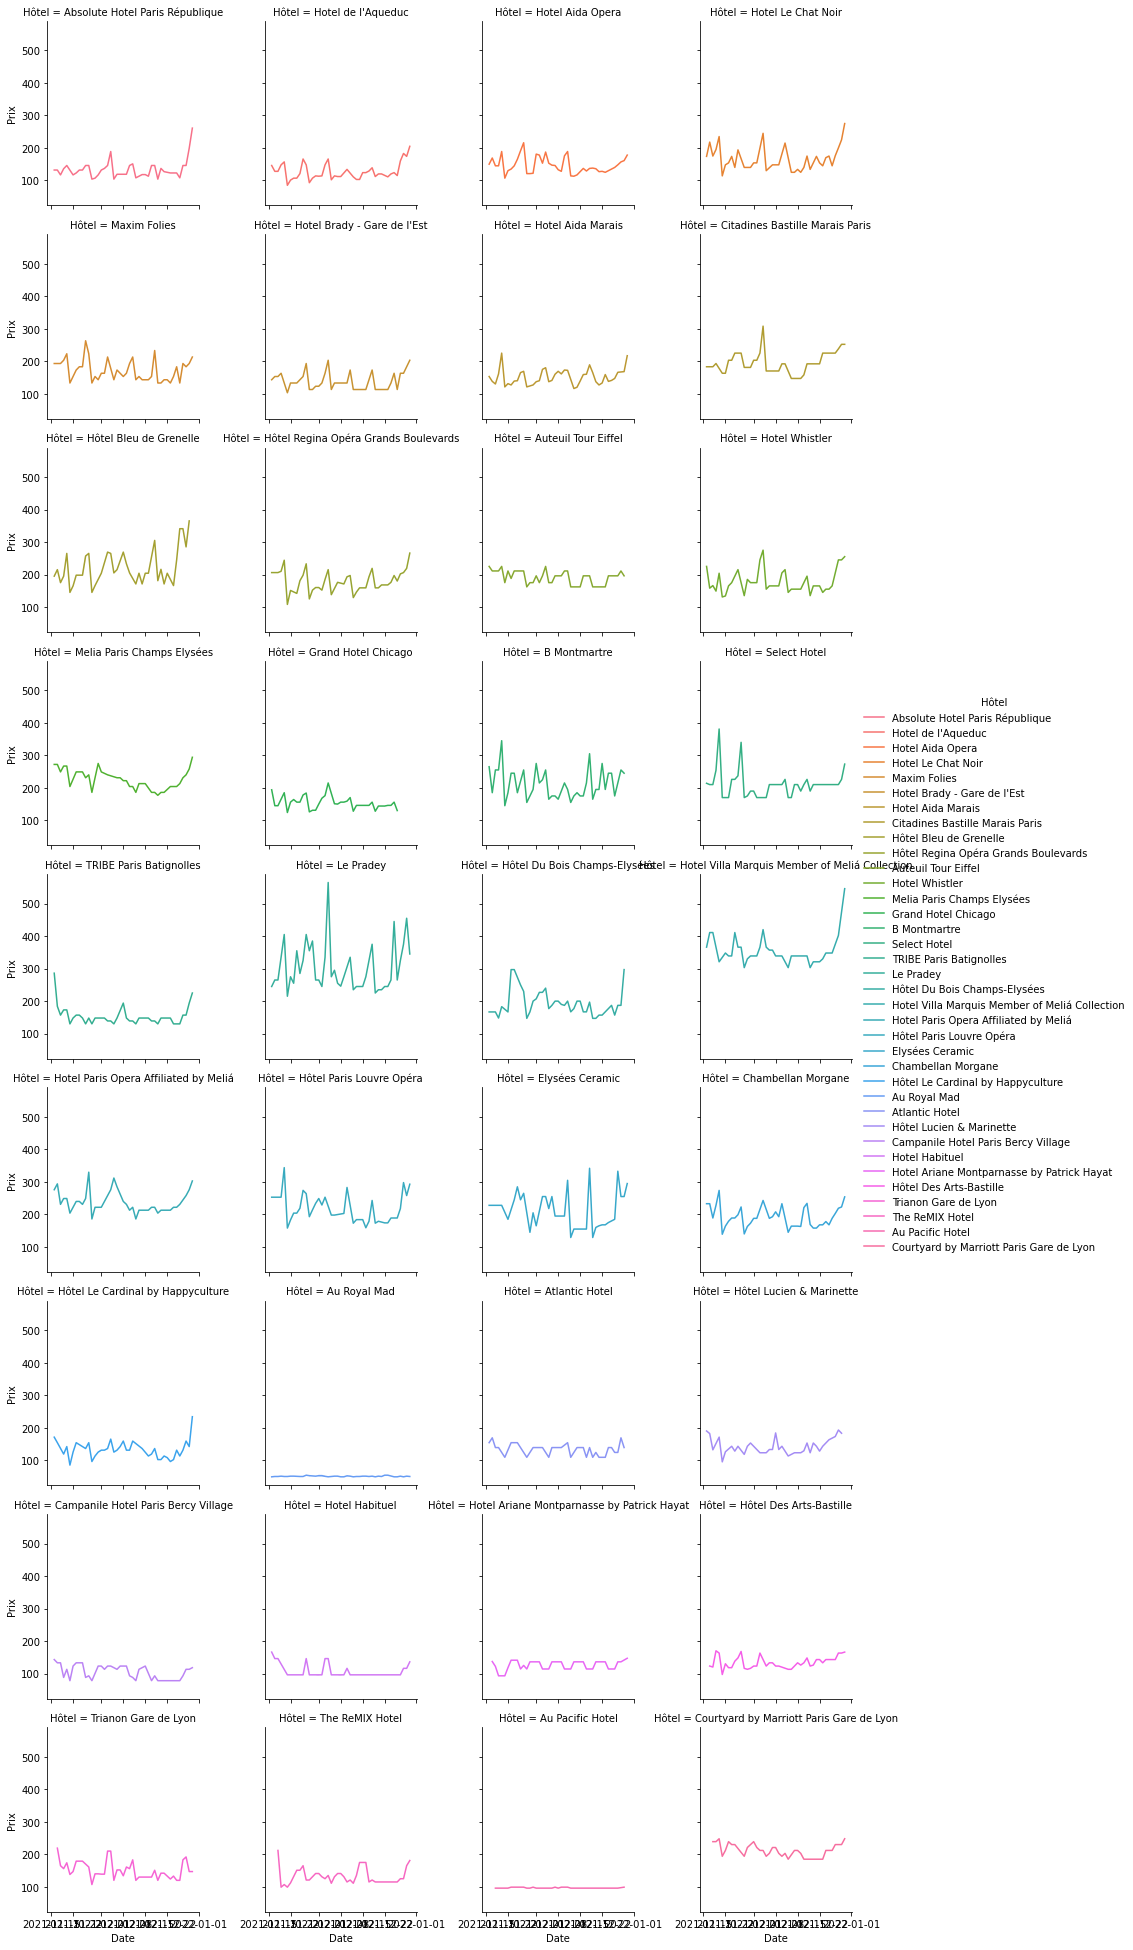

In [19]:
sns.relplot(x="Date", y="Prix", hue="Hôtel",col="Hôtel", col_wrap=4, height=3, kind="line", data=df_reduit)

On remarque une disparité dans l'évolution des prix en fonction des hôtels. En effet, pour certains hôtels, nous avons de fortes fluctuations des prix sur toute la période d'étude (ex : Le Pradey), tandis que pour d'autres, le prix est relativement stable (Royal Mad, Pacific Hôtel). Cela confirme bien les résultats sur la variance obtenus en fin de partie précédente.

# 2.3. Les facteurs temporels à l'origine des fluctuations de prix

Dans cette partie, nous analysons l'évolution des prix dans le secteur des hôtels à Paris. L'objectif est de déterminer, si c'est le cas, les jours pour lesquels les réservations sont plus chères dans un hôtel donné. Pour cette partie, nous n'avons pas besoin de la base de données réduite, nous pouvons utiliser la base de données complète.

In [20]:
df_Prix = df_data2.groupby('Date').agg([np.mean, np.std, np.min, np.max])['Prix'].reset_index()

In [21]:
df_Prix.head()

,Date,mean,std,amin,amax
0,2021-11-16,192.5154,78.403297,49.0,438.0
1,2021-11-17,181.6332,73.039774,50.0,467.0
2,2021-11-18,175.8476,77.664589,50.0,464.0
3,2021-11-19,153.9100,55.553068,51.0,338.0
4,2021-11-20,177.8700,74.486207,50.0,465.0


###### Visualisation des jours ayant les prix les plus élévés

Nous nous intéressons aux jours pour lesquels le prix moyen de réservation est le plus élevé. Le tableau ci-dessous montre que le prix est en moyenne plus important :
- lors des périodes de fêtes (fin décembre, surtout à l'approche du nouvel an)
- mi-novembre
- le samedi (20 novembre, 27 novembre, 4 décembre ; pour une nuit du samedi au dimanche).

Le fait que les prix soient plus élevés le week-end et lors des périodes de fêtes est dû au fait que les individus ont davantage de temps libre, qu'ils peuvent de fait consacrer au tourisme. La demande est plus importante à offre constante, ce qui conduit naturellement à la hausse des prix. Au contraire, en milieu de semaine, la plupart des individus travaillent, ce qui contribue à une demande réduite qui pousse les prix à la baisse. Les prix anormalement élevés à la mi-novembre (même en semaine) semblent liés au fait que le scraping des données a été effectué peu de temps avant cette période. Or, il est courant que les prix de réservation soient plus élevés lorsque l'on réserve tard.

In [22]:
df_Prix.sort_values(by ='mean',ascending=False).head(10)

,Date,mean,std,amin,amax
44,2021-12-30,203.9881,100.424582,50.0,626.0
0,2021-11-16,192.5154,78.403297,49.0,438.0
43,2021-12-29,186.2008,78.833042,51.0,482.0
18,2021-12-04,183.9005,91.261003,49.0,565.0
1,2021-11-17,181.6332,73.039774,50.0,467.0
8,2021-11-24,178.7800,80.161274,69.0,526.0
4,2021-11-20,177.8700,74.486207,50.0,465.0
11,2021-11-27,177.5400,83.804537,54.0,617.0
2,2021-11-18,175.8476,77.664589,50.0,464.0
42,2021-12-28,174.4108,68.683690,49.0,402.0


###### Graphique d'évolution des prix

Le graphique ci-dessous confirme nos remarques sur le précédent tableau : on constate une fluctuation des prix chaque semaine avec des creux en milieu de semaine, des pics chaque samedi et une augmentation importante à l'approche des festivités de la nouvelle année, à partir du 27 décembre.

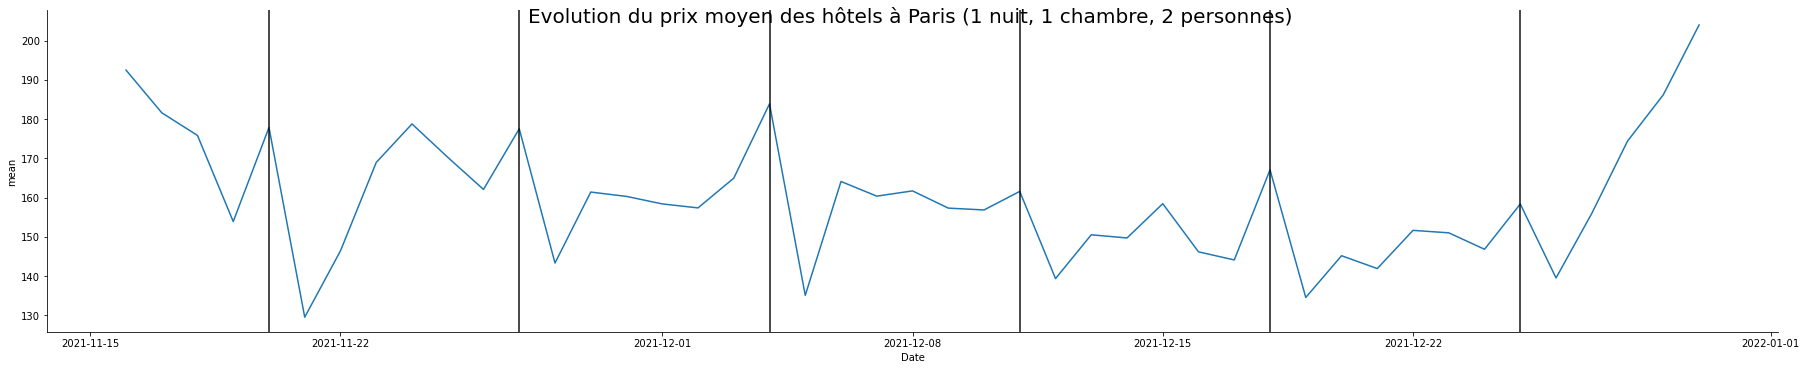

In [23]:
plot = sns.relplot(x="Date", y="mean", kind="line", data=df_Prix, aspect=5)
plot.fig.suptitle('Evolution du prix moyen des hôtels à Paris (1 nuit, 1 chambre, 2 personnes)', fontsize=20)
# Ajout d'une barre verticale chaque samedi
plot.axes[0][0].axvline(x = '2021-11-20', color='black', linewidth=2, alpha=.7)
plot.axes[0][0].axvline(x = '2021-11-27', color='black', linewidth=2, alpha=.7)
plot.axes[0][0].axvline(x = '2021-12-04', color='black', linewidth=2, alpha=.7)
plot.axes[0][0].axvline(x = '2021-12-11', color='black', linewidth=2, alpha=.7)
plot.axes[0][0].axvline(x = '2021-12-18', color='black', linewidth=2, alpha=.7)
plot.axes[0][0].axvline(x = '2021-12-25', color='black', linewidth=2, alpha=.7)